Multi Layer Perceptron @ Bengio

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Reading the dataset

In [64]:
words = open(file="names.txt", mode="r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [65]:
len(words)

32033

Building character to index and vice-versa mappings


In [66]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

Creating the dataset with context window

In [67]:
window = 3
X, Y = [], []

for w in words:

  # print(w)
  context = [0] * window
  for ch in w + ".":
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print("".join(itos[i] for i in context), "==>", itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [68]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

Lookup table

In [69]:
C = torch.randn(size=(27, 2))

In [70]:
embed = C[X]
embed.shape

torch.Size([228146, 3, 2])

In [71]:
W1 = torch.randn(size=(6, 100))
b1 = torch.randn(size=(100,))

In [72]:
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [73]:
W2 = torch.randn(size=(100, 27))
b2 = torch.randn(size=(27,))

In [74]:
logits = h @ W2 + b2

In [75]:
logits.shape

torch.Size([228146, 27])

In [76]:
counts = logits.exp()

In [77]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [115]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [138]:
gen = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(27, 2), generator=gen)
W1 = torch.randn(size=(6, 100), generator=gen)
b1 = torch.randn(size=(100,), generator=gen)
W2 = torch.randn(size=(100, 27), generator=gen)
b2 = torch.randn(size=(27,), generator=gen)

params = [C, W1, b1, W2, b2]

In [130]:
sum(p.nelement() for p in params)

3481

In [139]:
for p in params:

  p.requires_grad = True

In [140]:
loss_list = []

In [141]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [144]:
lri = []
lr_loss = []

for i in range(1000):

  # mini-batch
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  embed = C[X[ix]]
  h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  loss_list.append(loss.item())
  # print(loss.item())

  # backward pass
  lr = lrs[i]
  for p in params:
    p.grad = None

  loss.backward()

  # update
  for p in params:
    p.data += -lr * p.grad

  # stats
  # lri.append(lre[i])
  # lr_loss.append(loss.item())

8.415690422058105
8.736892700195312
6.531659126281738
8.620087623596191
7.795044422149658
6.717752933502197
7.230889320373535
7.390069961547852
8.918984413146973
7.746771812438965
7.435296058654785
7.919950485229492
7.478887557983398
7.680422306060791
8.912609100341797
8.173012733459473
7.147306442260742
9.354183197021484
8.146246910095215
8.764104843139648
7.0575175285339355
7.117008209228516
7.572350025177002
7.696352958679199
6.030171871185303
8.363642692565918
6.81466817855835
6.7461838722229
7.25269889831543
7.684964179992676
7.052951335906982
7.215804576873779
6.934999465942383
6.9128336906433105
10.074397087097168
8.236098289489746
7.583341598510742
8.922907829284668
9.02464485168457
7.823221683502197
7.846714019775391
6.326879978179932
7.2296671867370605
7.914005756378174
6.695469856262207
8.553443908691406
8.01334285736084
6.3002610206604
9.125061988830566
7.682183742523193
8.303997039794922
8.711145401000977
7.849808216094971
8.26669979095459
5.340823173522949
7.1940150260925

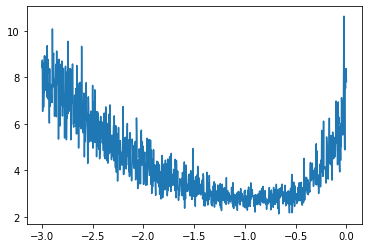

In [145]:
plt.plot(lri, lr_loss)